In [ ]:
# mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

# PyTorch
import torch
import torchvision
from torch import cuda
from torchvision import datasets, transforms, models
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary


import matplotlib.pyplot as plt
from PIL import Image


import json
from timeit import default_timer as timer
import os, random

In [ ]:
# categories
with open('drive/MyDrive/DB/cat_to_name.json', 'r') as f:
    category_name = json.load(f)

print('Classes number:', len(category_name), '\n')
print(category_name)

Classes number: 102 

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved po

In [ ]:
# Data paths
data_dir = 'drive/MyDrive/DB/flowers/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'
test_dir = data_dir + 'test/'

In [ ]:
# some information about our data
train_num = []
valid_num =[]
test_num = []
category_names = []

for label in os.listdir(train_dir):
    category_names.append(category_name[label])
    train_num.append(len(os.listdir(train_dir + '/' + label)))
    valid_num.append(len(os.listdir(valid_dir + '/' + label)))
    test_num.append(len(os.listdir(test_dir + '/' + label)))

# Putting it into a dataframe for easy manipulation
category_names_df = pd.DataFrame({
    'Category': category_names,
    'Train_num': train_num,
    'Valid_num': valid_num,
    'Test_num': test_num})

In [ ]:
print('Data samples in the Training set:', sum(category_names_df['Train_num']))
print('Data samples in the Validation set:', sum(category_names_df['Valid_num']))
print('Data samples in the Test set:', sum(category_names_df['Test_num']))

Data samples in the Training set: 6553
Data samples in the Validation set: 1031
Data samples in the Test set: 1027


In [ ]:
# most sample pictures
print(category_names_df.sort_values('Train_num', ascending=False).head(), '\n')
print(category_names_df.sort_values('Valid_num', ascending=False).head(), '\n')
print(category_names_df.sort_values('Test_num', ascending=False).head(), '\n')

          Category  Train_num  Valid_num  Test_num
50         petunia        206         10        10
76  passion flower        205         10        10
45      wallflower        157         10        10
88      watercress        153         10        10
72      water lily        147         18        10 

          Category  Train_num  Valid_num  Test_num
72      water lily        147         18        10
73            rose        142         12        10
18  balloon flower         38         11        10
0    pink primrose         27         10        10
77     lotus lotus        112         10        10 

                    Category  Train_num  Valid_num  Test_num
26  prince of wales feathers         36         10        15
28                 artichoke         62         10        12
52                   primula         70         10        10
75             morning glory         83         10        10
74               thorn apple         95         10        10 



Random training sample shape and image: (567, 500, 3) 



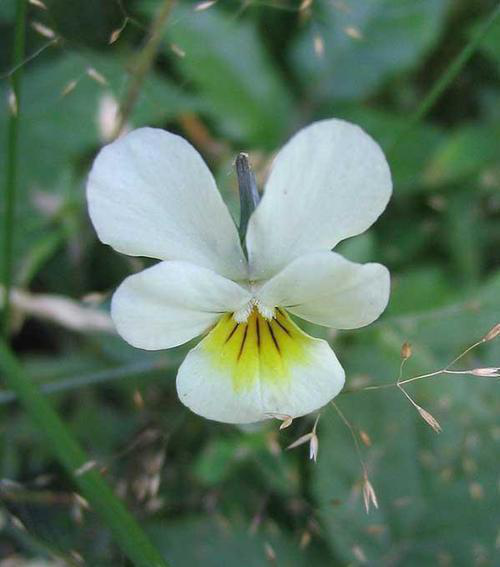

In [ ]:
random_class = random.choice(os.listdir(train_dir))
random_image = random.choice(os.listdir(train_dir + '/' + random_class))
img = Image.open(train_dir + random_class + '/' + random_image)
print('Random training sample shape and image:', np.array(img).shape, '\n')
img

In [ ]:
# Save the model in a file
save_file_name = 'flower_classifier.pt'
checkpoint_path = 'flower_classifier.pth'

In [ ]:
# Transforming the dataset(data augmentation)
data_transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(size=224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 
    
data_transforms_valid = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

data_transforms_test = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

In [ ]:
# Load the data into a suitable structure
image_dataset_train = torchvision.datasets.ImageFolder(train_dir, transform = data_transforms_train) 
image_dataset_valid = torchvision.datasets.ImageFolder(valid_dir, transform = data_transforms_valid)
image_dataset_test = torchvision.datasets.ImageFolder(test_dir, transform = data_transforms_test) 

# Pass to a data loader for batches
dataloader_train = torch.utils.data.DataLoader(image_dataset_train, shuffle=True, batch_size=32)
dataloader_valid = torch.utils.data.DataLoader(image_dataset_valid, shuffle=True, batch_size=32)
dataloader_test = torch.utils.data.DataLoader(image_dataset_test, shuffle=True, batch_size=32)

torch.Size([32, 3, 224, 224]) torch.Size([32])


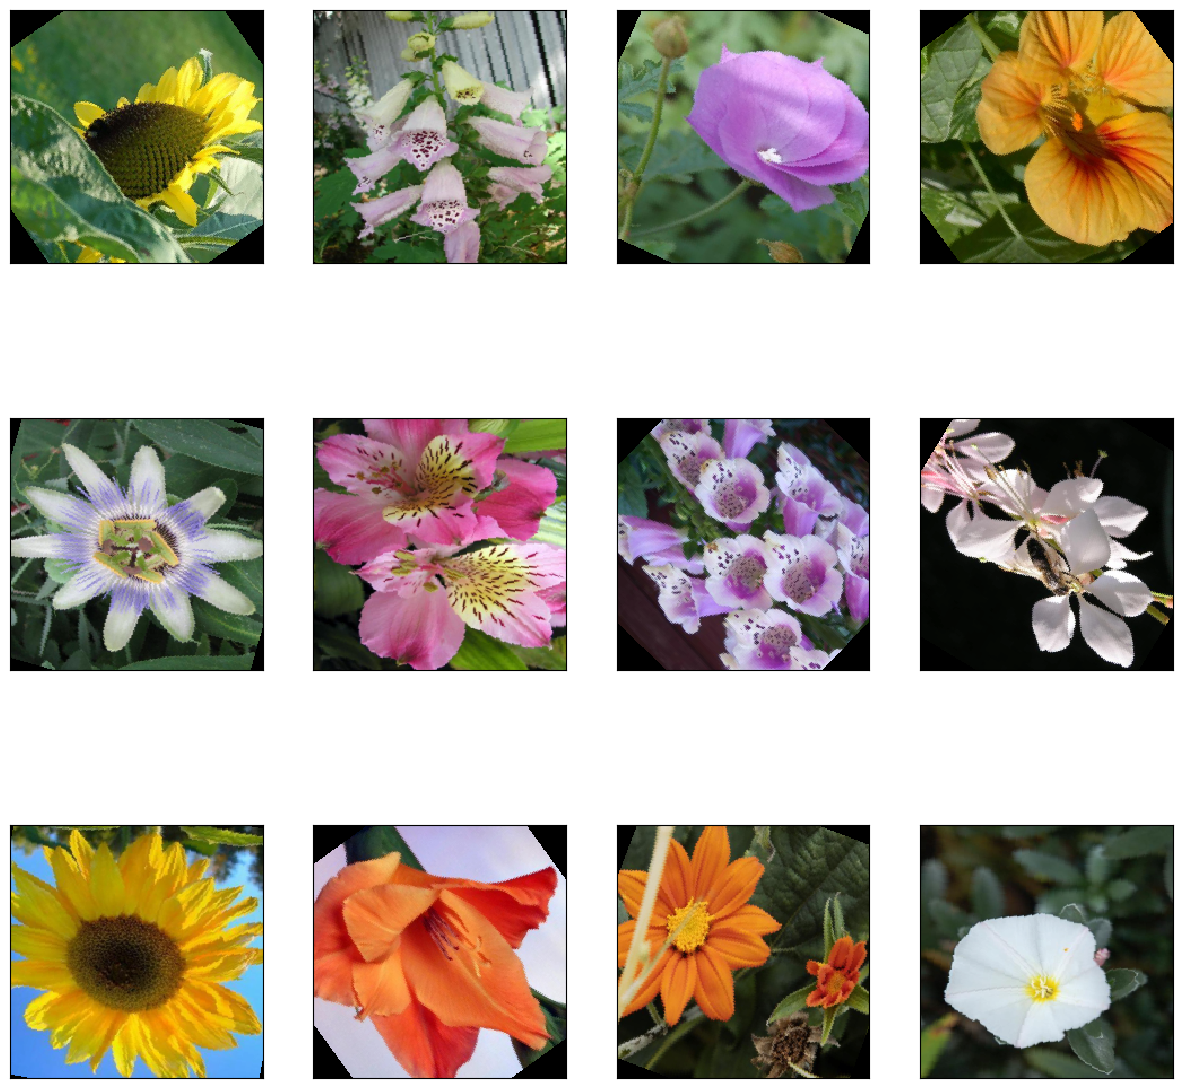

In [ ]:
# Visualizing images from the train dataloader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
images, labels = next(iter(dataloader_train))
print(images.shape, labels.shape)
rows = 3
columns = 4
fig=plt.figure(figsize=(15,15))
for i in range(12):
  fig.add_subplot(rows, columns, i+1)
  plt.title(None).set_visible(False)
  img = images[i].numpy().transpose((1, 2, 0))
  img = std * img + mean
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, interpolation='nearest')

plt.show()

In [ ]:
# Define the model
model = models.densenet161(weights="DenseNet161_Weights.IMAGENET1K_V1")

# the model's features parameters do not get updated as we train the classifier
for param in model.parameters():
    param.requires_grad = False

# Checking the model characteristics
print('\n', 'Model prior to modifications', '\n')
model

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 75.8MB/s]



 Model prior to modifications 



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
print('Model classifier before modifications')
print(model.classifier, '\n')


n_inputs = model.classifier.in_features # Getting the model's input size
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 1000),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(500, 102),
    nn.LogSoftmax(dim=1))

print('Model classifier after modifications', '\n')
print(model.classifier)

Model classifier before modifications
Linear(in_features=2208, out_features=1000, bias=True) 

Model classifier after modifications 

Sequential(
  (0): Linear(in_features=2208, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=500, out_features=102, bias=True)
  (7): LogSoftmax(dim=1)
)


In [ ]:
# Defining the training loss and optimizer after model going to GPU
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr= 0.001)

In [ ]:
def train(model, train_loader, valid_loader, criterion, optimizer, save_file_name, max_epochs=5, num_epochs=50, print_every=2):
    
    epochs_no_improve = 0
    overall_start = timer()
    valid_loss_min = np.Inf
    valic_acc_max = 0
    hist = []
    train_on_gpu = torch.cuda.is_available()
    
    for epoch in range(num_epochs):
        
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        # model to GPU
        if train_on_gpu:
          model.cuda()
        model.train()
        start = timer()
        
        # Training loop
        for ii, (data, target) in enumerate(dataloader_train):
            # Tensors to GPU
            if train_on_gpu:
              data, target = data.cuda(), target.cuda()
                
            # Main training steps
            optimizer.zero_grad()                 
            output = model(data)                  
            loss = criterion(output, target)      
            loss.backward()                     
            optimizer.step()                     
            
            # Loss and accuracy
            train_loss += loss.item() * data.size(0)         
            _, pred = torch.max(output, dim=1)              
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor)) 
            train_acc += accuracy.item() * data.size(0) 
                   
        # Validation
        with torch.no_grad():                     
            model.eval()                        

            # validation loop
            for data, target in dataloader_valid:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()      

                
                output = model(data)                              
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)

                # Accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            # Calculate average loss
            train_loss = train_loss / len(dataloader_train.dataset)
            valid_loss = valid_loss / len(dataloader_valid.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(dataloader_train.dataset)
            valid_acc = valid_acc / len(dataloader_valid.dataset)

            hist.append([train_loss, valid_loss, train_acc, valid_acc])

            # training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                torch.save(model.state_dict(), save_file_name)     
                print('Validation loss decreased -> Saving model')

                epochs_no_improve = 0                               
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= max_epochs:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    # Load the best state
                    model.load_state_dict(torch.load(save_file_name))
                    
                    model.optimizer = optimizer

                  
                    hist = pd.DataFrame(
                        hist,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    return model, hist

    model.optimizer = optimizer

    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    
    hist = pd.DataFrame(
        hist,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, hist

In [ ]:
model, hist = train(
    model,
    train_loader = dataloader_train,
    valid_loader = dataloader_valid,
    criterion = nn.NLLLoss(),
    optimizer = optim.Adam(model.classifier.parameters(), lr= 0.001),
    save_file_name = 'flower_classifier.pt',
    max_epochs = 5,
    num_epochs = 50,
    print_every = 1)


Epoch: 0 	Training Loss: 3.6777 	Validation Loss: 2.4581
		Training Accuracy: 17.55%	 Validation Accuracy: 33.66%
Validation loss decreased -> Saving model

Epoch: 1 	Training Loss: 1.8481 	Validation Loss: 1.2251
		Training Accuracy: 49.87%	 Validation Accuracy: 65.08%
Validation loss decreased -> Saving model

Epoch: 2 	Training Loss: 1.2760 	Validation Loss: 0.8800
		Training Accuracy: 63.19%	 Validation Accuracy: 75.17%
Validation loss decreased -> Saving model

Epoch: 3 	Training Loss: 1.0394 	Validation Loss: 0.7038
		Training Accuracy: 70.23%	 Validation Accuracy: 82.25%
Validation loss decreased -> Saving model

Epoch: 4 	Training Loss: 0.9157 	Validation Loss: 0.5900
		Training Accuracy: 73.58%	 Validation Accuracy: 83.61%
Validation loss decreased -> Saving model

Epoch: 5 	Training Loss: 0.8200 	Validation Loss: 0.5170
		Training Accuracy: 76.53%	 Validation Accuracy: 86.03%
Validation loss decreased -> Saving model

Epoch: 6 	Training Loss: 0.7326 	Validation Loss: 0.4165


In [ ]:
train_on_gpu = torch.cuda.is_available()

In [ ]:
def accuracy_all(output, target, topk=(1, )):
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())

        acc[0] = acc[0] + res[0]
        acc[1] = acc[1] + res[1]

In [ ]:
# Calculating the average accuracy on the test set for all batches
acc = [0,0]
for i, (features, targets) in enumerate(dataloader_test):
    if train_on_gpu:
        model.to('cuda')
        accuracy_all(model(features.to('cuda')), targets, topk=(1, 5))
    else:
        accuracy(model(features), targets, topk=(1, 5))
print('Top 1 Accuracy:', round(acc[0]/len(dataloader_test), 1))
print('Top 5 Accuracy:', round(acc[1]/len(dataloader_test), 1))

Top 1 Accuracy: 96.1
Top 5 Accuracy: 99.5


In [ ]:
# Saving checkpoint
model.class_to_idx = dataloader_train.dataset.class_to_idx
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloader_train.batch_size,
                  'output_size': 102,
                  'state_dict': model.state_dict(),
                  'optimizer': model.optimizer,
                  'optimizer_dict':optimizer.state_dict(),
                  'optimizer_state_dict': model.optimizer.state_dict(),
                  'classifier': model.classifier,
                  'class_to_idx': model.class_to_idx}
path = f"/content/drive/MyDrive/DB/" + checkpoint_path
torch.save(checkpoint, path)

In [ ]:
!ls

drive  flower_classifier.pt  flower_classifier.pth  sample_data
